# ABC Analysis Implementation (Solution)

You're a supply chain analyst at ElectroMart, a consumer electronics retailer. You need to categorize inventory items based on their annual dollar volume using ABC analysis. You have data for 50 different products including their annual demand and unit cost.

ABC Analysis Categories:
- A items: Top 70-80% of annual dollar volume
- B items: Next 15-20% of annual dollar volume
- C items: Bottom 5-10% of annual dollar volume

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Part 1: Data Preparation

Load and prepare the inventory data.

In [14]:
# Generate sample data
np.random.seed(42)
n_products = 50

# Create sample data
data = {
    'Product_ID': [f'P{i:03d}' for i in range(1, n_products + 1)],
    'Annual_Demand': np.random.randint(100, 10000, n_products),
    'Unit_Cost': np.random.uniform(10, 1000, n_products)
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Calculate annual dollar volume
df['Annual_Volume'] = df['Annual_Demand'] * df['Unit_Cost']

# Sort by annual volume in descending order
df = df.sort_values('Annual_Volume', ascending=False).reset_index(drop=True)

# Calculate percentage of total volume
total_volume = df['Annual_Volume'].sum()
df['Volume_Percentage'] = (df['Annual_Volume'] / total_volume) * 100

# Calculate cumulative percentage
df['Cumulative_Percentage'] = df['Volume_Percentage'].cumsum()

# Display first few rows
df.head()

,Product_ID,Annual_Demand,Unit_Cost,Annual_Volume,Volume_Percentage,Cumulative_Percentage
0,P041,8892,851.538192,7.571878e+06,5.742925,5.742925
1,P046,9655,669.263133,6.461736e+06,4.900933,10.643858
2,P039,8938,654.566255,5.850513e+06,4.437348,15.081206
3,P023,9374,590.883654,5.538943e+06,4.201037,19.282243
4,P040,5493,915.810079,5.030545e+06,3.815440,23.097683


In [15]:
# Answer analysis questions
print(f"Total annual dollar volume: ${total_volume:,.2f}")
print(f"Range of annual dollar volumes: ${df['Annual_Volume'].min():,.2f} to ${df['Annual_Volume'].max():,.2f}")
print(f"Number of products making up 80% of volume: {len(df[df['Cumulative_Percentage'] <= 80])}")
print(f"Average unit cost: ${df['Unit_Cost'].mean():,.2f}")

Total annual dollar volume: $131,847,053.34
Range of annual dollar volumes: $7,363.73 to $7,571,877.60
Number of products making up 80% of volume: 24
Average unit cost: $520.37


## Part 2: ABC Classification

Classify products into A, B, and C categories based on the cumulative percentage thresholds.

In [16]:
# Assign ABC categories
def assign_category(cum_pct):
    if cum_pct <= 80:  # A items: first 80%
        return 'A'
    elif cum_pct <= 95:  # B items: next 15%
        return 'B'
    else:  # C items: last 5%
        return 'C'

df['Category'] = df['Cumulative_Percentage'].apply(assign_category)

# Calculate summary statistics by category
summary = df.groupby('Category').agg({
    'Product_ID': 'count',
    'Annual_Volume': 'sum',
    'Unit_Cost': 'mean'
}).round(2)

summary['Volume_Percentage'] = (summary['Annual_Volume'] / total_volume * 100).round(2)
summary['Items_Percentage'] = (summary['Product_ID'] / len(df) * 100).round(2)

print("ABC Analysis Summary:")
print("\nNumber of items and volume by category:")
print(summary)

ABC Analysis Summary:

Number of items and volume by category:
          Product_ID  Annual_Volume  Unit_Cost  Volume_Percentage  \
Category                                                            
A                 24   1.044401e+08     689.24              79.21   
B                 14   2.067036e+07     394.19              15.68   
C                 12   6.736610e+06     329.85               5.11   

          Items_Percentage  
Category                    
A                     48.0  
B                     28.0  
C                     24.0  


## Part 3: Inventory Policy Recommendations

Develop inventory management policies for each category.

In [17]:
# Define inventory policies
inventory_policies = {
    'A': {
        'review_frequency': 'Weekly',
        'review_period_days': 7,
        'service_level': 0.99,
        'safety_stock_days': 3
    },
    'B': {
        'review_frequency': 'Bi-weekly',
        'review_period_days': 14,
        'service_level': 0.95,
        'safety_stock_days': 7
    },
    'C': {
        'review_frequency': 'Monthly',
        'review_period_days': 30,
        'service_level': 0.90,
        'safety_stock_days': 14
    }
}

# Apply policies to each product
for category in ['A', 'B', 'C']:
    mask = df['Category'] == category
    policy = inventory_policies[category]
    
    # Calculate daily demand
    df.loc[mask, 'Daily_Demand'] = df.loc[mask, 'Annual_Demand'] / 365
    
    # Calculate safety stock
    df.loc[mask, 'Safety_Stock'] = df.loc[mask, 'Daily_Demand'] * policy['safety_stock_days']
    
    # Calculate order quantity (simple EOQ approximation)
    df.loc[mask, 'Order_Quantity'] = np.sqrt(2 * df.loc[mask, 'Annual_Demand'] * 100 / (0.2 * df.loc[mask, 'Unit_Cost']))

# Display policy summary
print("Inventory Policy Summary by Category:\n")
for category, policy in inventory_policies.items():
    print(f"Category {category}:")
    print(f"  Review Frequency: {policy['review_frequency']}")
    print(f"  Service Level: {policy['service_level']*100}%")
    print(f"  Safety Stock Days: {policy['safety_stock_days']}")
    print()

Inventory Policy Summary by Category:

Category A:
  Review Frequency: Weekly
  Service Level: 99.0%
  Safety Stock Days: 3

Category B:
  Review Frequency: Bi-weekly
  Service Level: 95.0%
  Safety Stock Days: 7

Category C:
  Review Frequency: Monthly
  Service Level: 90.0%
  Safety Stock Days: 14



## Part 4: Visualization

Create visual representations of the ABC analysis.

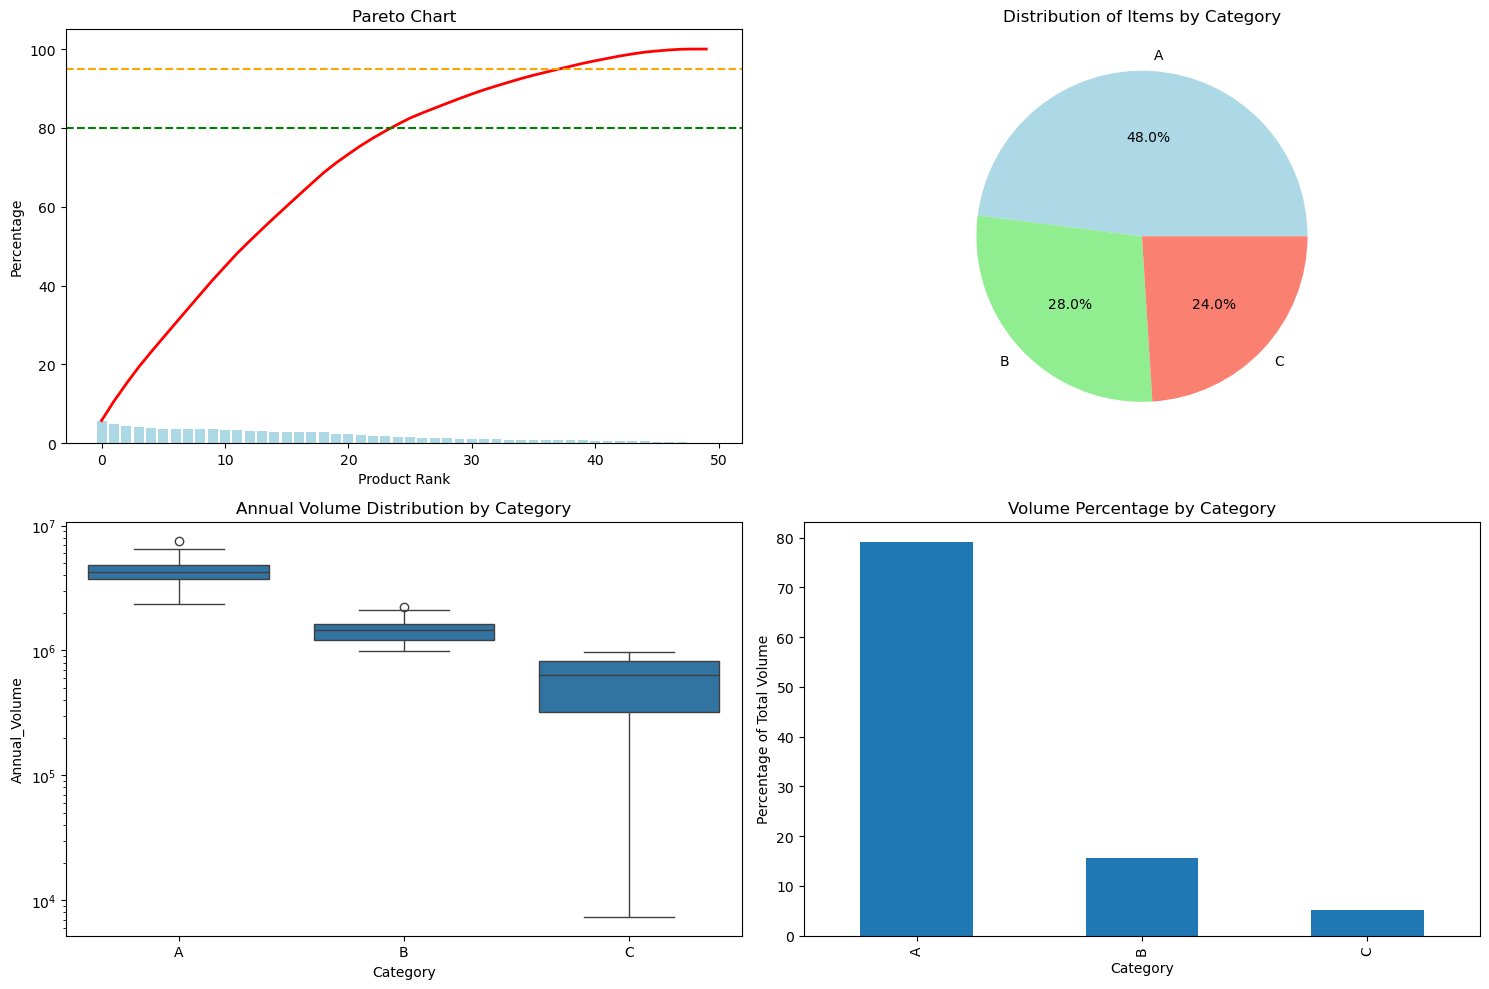

In [18]:
# Create figure with multiple subplots
fig = plt.figure(figsize=(15, 10))

# 1. Pareto Chart
ax1 = plt.subplot(2, 2, 1)
ax1.bar(range(len(df)), df['Volume_Percentage'], color='lightblue')
ax1.plot(range(len(df)), df['Cumulative_Percentage'], color='red', linewidth=2)
ax1.set_title('Pareto Chart')
ax1.set_xlabel('Product Rank')
ax1.set_ylabel('Percentage')
ax1.axhline(y=80, color='green', linestyle='--')
ax1.axhline(y=95, color='orange', linestyle='--')

# 2. Category Distribution
ax2 = plt.subplot(2, 2, 2)
category_counts = df['Category'].value_counts()
ax2.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%',
        colors=['lightblue', 'lightgreen', 'salmon'])
ax2.set_title('Distribution of Items by Category')

# 3. Box Plot of Annual Volume by Category
ax3 = plt.subplot(2, 2, 3)
sns.boxplot(x='Category', y='Annual_Volume', data=df, ax=ax3)
ax3.set_title('Annual Volume Distribution by Category')
ax3.set_yscale('log')

# 4. Bar Plot of Volume Percentage by Category
ax4 = plt.subplot(2, 2, 4)
volume_by_category = df.groupby('Category')['Annual_Volume'].sum() / total_volume * 100
volume_by_category.plot(kind='bar', ax=ax4)
ax4.set_title('Volume Percentage by Category')
ax4.set_ylabel('Percentage of Total Volume')

plt.tight_layout()
plt.show()